Знакомство с библиотекой scikit-learn.
Эта библиотека включает в себя множество алгоритмов, несколько тестовых наборов данных, функции для подсчета метрик и подбора параметров

Возьмем стандартный датасет c помощью функции fetch_california_housing. Датасет содержит информацию о ценах на квартиры и какие-то параметры квартиры.

In [1]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()

Посмотрим названия признаков

In [2]:
data['feature_names']

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [7]:
print(data.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])


Изучим описание датасета

In [8]:
print(data['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

Посмотрим на целевую переменную

In [9]:
data['target']

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выделим из датасета признаки и целевую переменную

In [10]:
X, y = data['data'], data['target']

In [11]:
print("Размер матрицы объектов: ", X.shape)
print("Рaзмер вектора y: ", y.shape)

Размер матрицы объектов:  (20640, 8)
Рaзмер вектора y:  (20640,)


Посмотрим на наши данные. Построим  график того, как зависит цена от среднего количества комнат. Для этого воспользуемся библиотекой matplotlib.

In [12]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'Price')

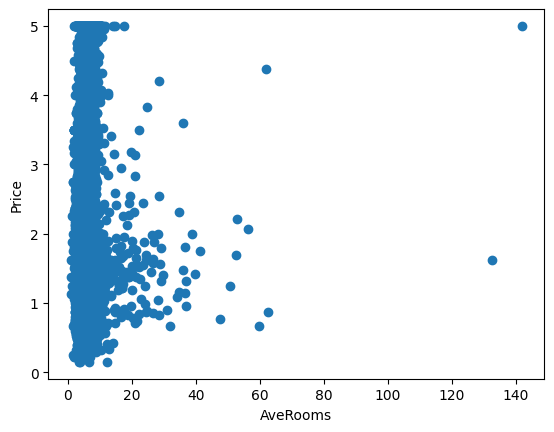

In [13]:
plt.scatter(X[:, 2], y)
plt.xlabel('AveRooms')
plt.ylabel('Price')

Подготовим выбоку для обучения

In [14]:
from sklearn.model_selection import train_test_split

С помощью функции `train_test_split` разобьем выборку на `train` и `test`.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

В sklearn, разные методы лежат в разных модулях. Например в linear_model находятся линейные модели, в neighbors - методы основанные на ближайших соседях.

Импортируем алгоритм knn из sklearn. Работа с алгоритмами машинного обучения в библиотеке состоит из трех этапов.



1.   Создание объекта, который будет реализовывать алгоритм.
2.   Вызов `fit`: обучение модели на тренировочной подвыборке
3.   Вызов `predict`: получение предсказаний на тестовой выборке



In [17]:
knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', p=2)

In [18]:
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [19]:
predictions = knn.predict(X_test)

Мы получили предсказания. Посчитаем метрику, соответствующая функция есть в scikit-learn! Будет считать средне квадратичную ошибку, так как мы решаем задачу регрессии.

In [20]:
from sklearn.metrics import mean_squared_error

In [21]:
mean_squared_error(y_test, predictions)

1.102678545047372

Давайте попробуем сделать лучше! У нашего алгоритма есть множество гиперпараметров: количество соседей, параметры метрики и веса. Запустим поиск по сетке гиперараметров, алгоритм переберет все возможные комбинации, посчитает метрику для каждого набора и выдаст лучший набор.

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
grid_searcher = GridSearchCV(KNeighborsRegressor(),
                             param_grid={'n_neighbors': range(1, 40, 2),
                                         'weights': ['uniform', 'distance'],
                                         'p': [1, 2, 3]},
                             cv=5)

Параметр cv=5 говорит, что во время поиска оптимальных парамертов будет использоваться кросс-валидация с 5 фолдами.
В нашем случае, выборка будет разделена на 5 частей и на каждой из 5 итераций, часть данных будет становиться тестовой выборкой, а другая часть - обучающей. Посчитав метрики на каждой итерации, мы сможем усреднить их в конце и получить достаточно точную оценку качества нашего алгоритма.

In [24]:
grid_searcher.fit(X_train, y_train);

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Выведем предсказание лучшей модели.

In [25]:
best_predictions = grid_searcher.predict(X_test)

In [26]:
mean_squared_error(y_test, best_predictions)

0.948195192690429

Посмотрим лучшие параметры модели

In [27]:
grid_searcher.best_params_

{'n_neighbors': 11, 'p': 1, 'weights': 'distance'}

Посмотрим на качество алгоритма в зависимости от количества соседей. Качество будем оценивать на обучающей выборке


In [28]:
from sklearn.model_selection import cross_val_score
import numpy as np

In [29]:
metrics = []
for n in range(1, 40, 2):
  knn = KNeighborsRegressor(n_neighbors=n)
  scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  metrics.append(np.mean(scores))

In [30]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'Number of neightbors')

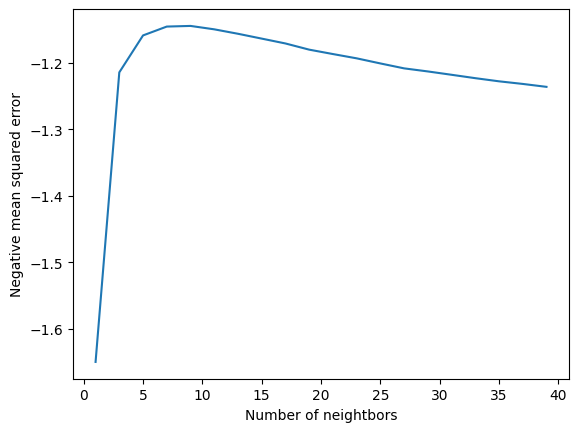

In [31]:
plt.plot(range(1, 40, 2), metrics)
plt.ylabel('Negative mean squared error')
plt.xlabel('Number of neightbors')

Помимо готовых датасетов, в библиотеке sklearn можно найти функции для генерации искусственных данных. Давайте сгенерируем датасет для классификации и визуализируем его.

In [32]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.2)

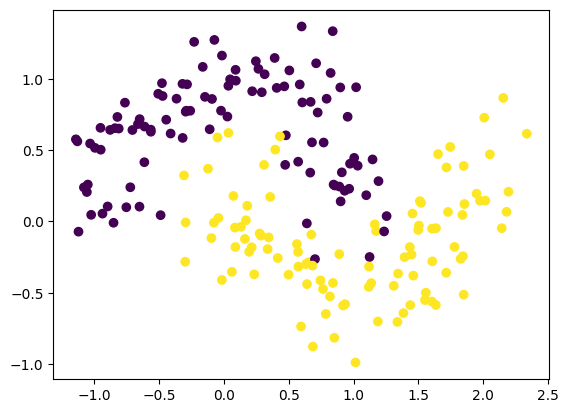

In [33]:
plt.scatter(X[:, 0], X[:, 1], c=y)

Получили два слегка зашумленных месяца. Обучим knn на этих данных и визуализируем пространство предсказаний.



In [34]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)

knn_clf.fit(X, y)

KNeighborsClassifier()

Для визуализации построим массив, который будет содержать в себе все точки в окрестности данных с некоторым шагом.

In [35]:
x_grid, y_grid = np.meshgrid(np.linspace(-2.0, 3.0, 100), np.linspace(-2.0, 2.0, 100))
xy = np.stack([x_grid, y_grid], axis=2).reshape(-1, 2)
xy

array([[-2.        , -2.        ],
       [-1.94949495, -2.        ],
       [-1.8989899 , -2.        ],
       ...,
       [ 2.8989899 ,  2.        ],
       [ 2.94949495,  2.        ],
       [ 3.        ,  2.        ]])

In [36]:
predicted = knn_clf.predict(xy)

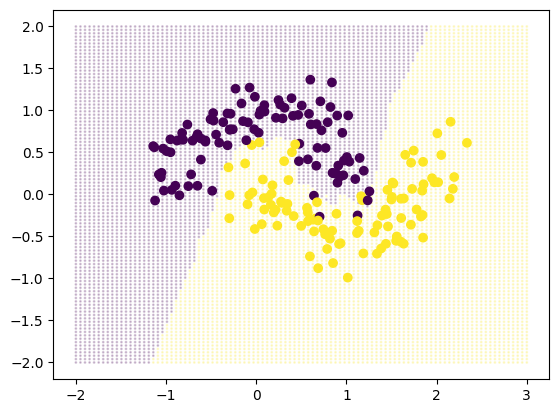

In [37]:
plt.scatter(xy[:, 0], xy[:, 1], c=predicted, alpha=0.2, s=1)
plt.scatter(X[:, 0], X[:, 1], c=y)

На картинке вы можете увидеть исходные данные и границу, которую knn провел между классами. Поэксперементируйте с параметром n_neighbors и посмотрите, как он влияет на итоговый результат.